<a href="https://colab.research.google.com/github/sina-salmanpour/False_memory_PTSD/blob/main/PTSD_Flase_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Entirly Reviewing flow

In [ ]:
# Import libraries
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Clean Data (example for verbal PTSD)
df = pd.read_excel('ptsd_verbal.xlsx')
# ... (pivot, split response/RT, filter RT > 200 & < 5000, exclude negatives)
df['group'] = 'PTSD'  # Repeat for other files, concatenate

# Step 2: Aggregates
agg_df = df.groupby(['subject', 'group', 'emotion', 'item_type']).agg(
    rate=('response', 'mean'),  # Hit/false memory/false alarm
    rt_mean=('rt', 'mean')     # Mean RT for yes
).reset_index()

# Step 3: Normality (Shapiro-Wilk)
for group in agg_df['group'].unique():
    for emotion in agg_df['emotion'].unique():
        rt_data = agg_df[(agg_df['group'] == group) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == 'CL')]['rt_mean']
        if len(rt_data) > 2:
            stat, p = stats.shapiro(rt_data)
            print(f'{group}-{emotion}: Shapiro p={p}')

# Step 4: ANOVA (example for false memory rate)
model = ols('rate ~ C(group) * C(emotion)', data=agg_df[agg_df['item_type'] == 'CL']).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Non-Parametric Alternative (Kruskal-Wallis)
groups = [agg_df[(agg_df['group'] == g) & (agg_df['item_type'] == 'CL') & (agg_df['emotion'] == 'NT')]['rate'] for g in ['PTSD', 'Non-PTSD', 'Control']]
stat, p = stats.kruskal(*groups)
print(f'Kruskal NT: p={p}')

# Visuals
sns.barplot(data=agg_df[agg_df['item_type'] == 'CL'], x='emotion', y='rate', hue='group')
plt.title('False Memory Rates')
plt.savefig('false_memory_bar.png')  # For thesis inclusion

FileNotFoundError: [Errno 2] No such file or directory: 'ptsd_verbal.xlsx'

## Stepping down by detail

### version one 1

In [1]:
# 1. Import Libraries
import pandas as pd  # Core for DataFrames, reading CSVs, grouping
import numpy as np   # Numerical operations, e.g., NaN handling
from scipy import stats  # For future normality (Shapiro-Wilk)
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns  # Advanced visuals (e.g., boxplots for RT)
import os  # File path handling
import warnings  # Suppress warnings for clean output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility (if sampling later)
np.random.seed(42)

# Display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)       # Auto-width

print("Libraries imported successfully. Ready for data loading.")

Libraries imported successfully. Ready for data loading.


In [ ]:
import pandas as pd
import numpy as np
import os

# Simplified file paths (list instead of dict for ease; group from key)
files = {
    'verbal_PSTD': '/content/drive/MyDrive/AmirFarhang/ptsd_verbal.xlsx',
    'verbal_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_verbal.xlsx',
    'verbal_Control': '/content/drive/MyDrive/AmirFarhang/control_verbal.xlsx',
    'video_PSTD': '/content/drive/MyDrive/AmirFarhang/ptsd_video.xlsx',
    'video_Non-PTSD': '/content/drive/MyDrive/AmirFarhang/non_ptsd_visual.xlsx',
    'video_Control': '/content/drive/MyDrive/AmirFarhang/control_video.xlsx'
}

# Function to process and save one file
def process_file(file_path, file_key):
    """
    Load XLSX, drop 'Subject' column, extract response/RT with custom logic, handle negatives/two-digit, save _modified.
    Args:
        file_path (str): Path to file.
        file_key (str): 'verbal_PSTD' etc. for group/task extraction.
    Returns:
        pd.DataFrame: Processed long format.
    """
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}. Skipping.")
        return None

    df = pd.read_excel(file_path)

    # Drop 'Subject' column if exists (as per user: it's words, deleted/empty)
    if 'Subject' in df.columns:
        df = df.drop(columns=['Subject'])

    # Extract task and group from key
    task_type, group_name = file_key.split('_')

    # Identify candidate (subject) columns (starting with 'Sub', 'SubP', etc.)
    candidate_cols = [col for col in df.columns if col.startswith(('Sub', 'SubP', 'Subh', 'subh', 'subp'))]

    # Other columns: 'answer' (item_type), unnamed third (emotion), etc.
    id_vars = [col for col in df.columns if col not in candidate_cols]

    # Melt to long (pivot candidates to rows)
    df_long = pd.melt(df, id_vars=id_vars, value_vars=candidate_cols,
                      var_name='candidate', value_name='value')

    # Add group and task
    df_long['group'] = group_name
    df_long['task'] = task_type

    # For videos: Assign emotion blocks (rows 1-26=O, etc.; use reset index for row num)
    df_long = df_long.reset_index()  # Add row index for block assignment
    # if task_type == 'video':
    #     df_long['emotion'] = np.where(df_long['index'] < 26, 'O',  # 0-based index, rows 0-25 = O (1-26)
    #                                   np.where(df_long['index'] < 51, 'NT',
    #                                            np.where(df_long['index'] < 76, 'P', 'N')))

    # # For verbal: Unnamed third column is emotion (assume column index 1, since Subject dropped; cols[0]='answer', cols[1]=emotion)
    # else:
    emotion_col = df.columns[1] if len(df.columns) > 1 else None  # Second col after 'answer'
    if emotion_col:
        df_long['emotion'] = df_long[emotion_col]
    else:
        df_long['emotion'] = 'Unknown'  # Fallback

    # Map item_type from 'answer' (flag column)
    if 'answer' in df_long.columns:
        df_long['item_type'] = df_long['answer'].map({1: 'Target', 0: 'New', 'CL': 'Lure', np.nan: 'Unknown'})
    else:
        df_long['item_type'] = 'Unknown'


    # Custom extract response (0/1) and rt (float in seconds)
    def extract_response_rt(val):
        if pd.isna(val) or (isinstance(val, (int, float)) and val < 0):
            return "NAN", "NAN"  # NA for NaN/negatives


        val_str = str(val).replace(',', '')  # Remove commas if any (e.g., 15,757 → 15757)
        response = "NAN"
        rt = "NAN"

        if '.' in val_str:
            before, after = val_str.split('.')

        else:
            before, after = val_str, '0'

            if '-' in before:
                before , response = "NAN" , "NAN"


        # Response = first digit (0 or 1)

        if before and before[0] in '01':
            response = int(before[0])


        # RT = rest + '.' + after as float (in seconds)
        rt_str = before[1:] + '.' + after if len(before) > 1 else '0.' + after
        try:
            rt = float(rt_str)
        except ValueError:
            rt = "NAN"
        if response == "NAN":
            rt = "NAN"

        #print(response, rt)
        return response, rt

    df_long[['response', 'rt']] = df_long.apply(lambda row: extract_response_rt(row['value']), axis=1, result_type='expand')

    # Drop original 'value' and any temp cols (e.g., index)
    df_long = df_long.drop(columns=['value', 'index'] if 'index' in df_long.columns else ['value'])
    # Replace all "NAN" string values with proper np.nan in relevant numeric columns
    for col in ['response', 'rt']:
        if col in df_long.columns:
            df_long[col] = df_long[col].replace("NAN", np.nan)

    df_long['response'] = pd.to_numeric(df_long['response'], errors='coerce')
    df_long['rt'] = pd.to_numeric(df_long['rt'], errors='coerce')

    # Save _modified in same path (as .xlsx)
    base_dir = os.path.dirname(file_path)
    base_name = os.path.basename(file_path)
    modified_name = base_name.replace('.xlsx', '_modified.xlsx')
    modified_path = os.path.join(base_dir, modified_name)
    df_long.to_excel(modified_path, index=False)
    print(f"Saved modified file: {modified_path}")

    return df_long

# Process all files
all_data = []
for file_key, path in files.items():
    processed = process_file(path, file_key)
    if processed is not None:
        all_data.append(processed)

# Optional: Concat all for full analysis, save
if all_data:
    full_df = pd.concat(all_data, ignore_index=True)
    full_df.to_excel('/content/drive/MyDrive/AmirFarhang/full_processed.xlsx', index=False)
    print("All files processed and full_processed saved.")
else:
    print("No files processed.")

Saved modified file: /content/drive/MyDrive/AmirFarhang/ptsd_verbal_modified.xlsx
Saved modified file: /content/drive/MyDrive/AmirFarhang/non_ptsd_verbal_modified.xlsx
Saved modified file: /content/drive/MyDrive/AmirFarhang/control_verbal_modified.xlsx
Saved modified file: /content/drive/MyDrive/AmirFarhang/ptsd_video_modified.xlsx
Saved modified file: /content/drive/MyDrive/AmirFarhang/non_ptsd_visual_modified.xlsx
Saved modified file: /content/drive/MyDrive/AmirFarhang/control_video_modified.xlsx
All files processed and full_processed saved.


Loaded 13352 rows post-NaN filter.
Descriptives Summary:
       group    task emotion  mean_hit    sd_hit  mean_false_memory  \
0    Control  verbal       N  0.296717  0.333374           0.196212   
1    Control  verbal      NT  0.392540  0.410472           0.271212   
2    Control  verbal       O  0.316123  0.339820           0.245202   
3    Control  verbal       P  0.333838  0.355788           0.186364   
4    Control  verbal       U  0.000000  0.000000           0.000000   
5    Control   video       N  0.168889  0.251685           0.190432   
6    Control   video      NT  0.222222  0.321152           0.174321   
7    Control   video       O  0.231505  0.337163           0.120370   
8    Control   video       P  0.159596  0.249082           0.139506   
9   Non-PTSD  verbal       N  0.246447  0.304589           0.154167   
10  Non-PTSD  verbal      NT  0.355595  0.402671           0.239015   
11  Non-PTSD  verbal       O  0.245726  0.282096           0.193561   
12  Non-PTSD  verbal

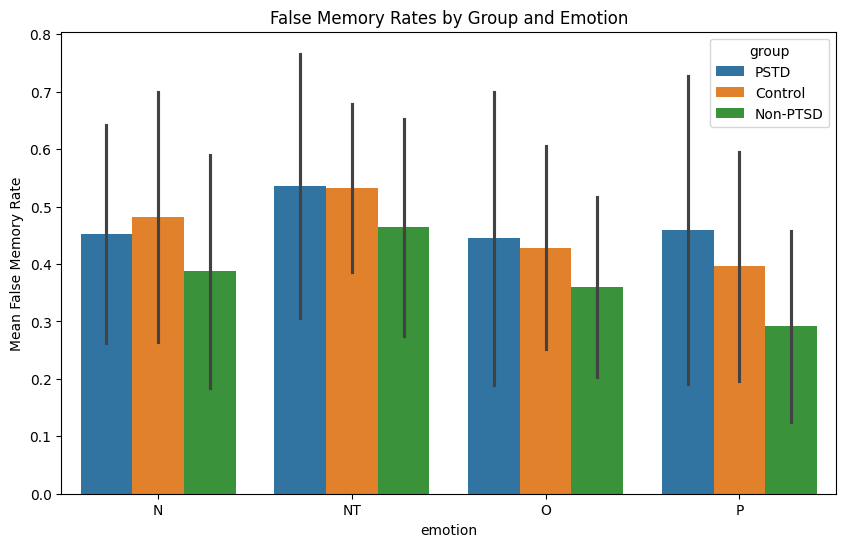

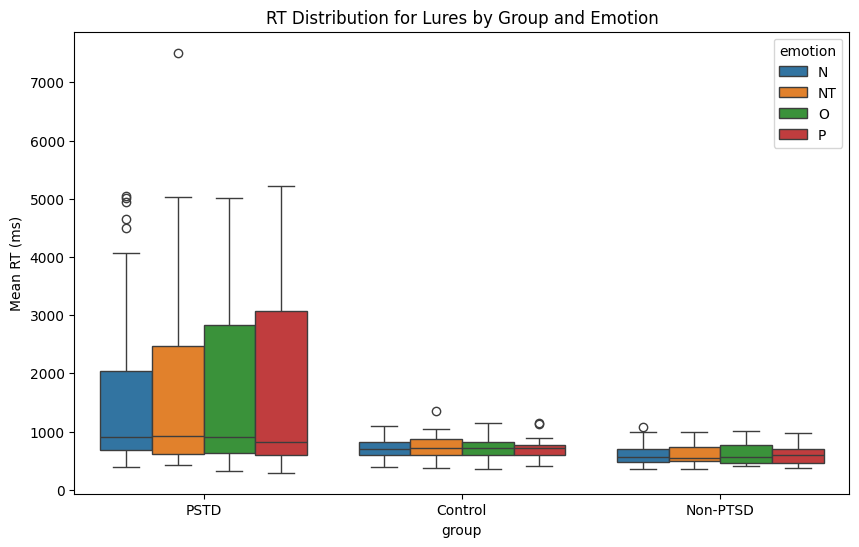

Initial Analysis complete. Files saved in Drive.


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load full_processed (or concatenate modified if needed)
full_path = '/content/drive/MyDrive/AmirFarhang/full_processed.xlsx'
df = pd.read_excel(full_path)

# Filter out NaNs in response/rt for analysis (per your request)
df = df.dropna(subset=['response', 'rt'])

print(f"Loaded {len(df)} rows post-NaN filter.")

# Aggregate per subject/group/task/emotion/item_type
agg_df = df.groupby(['candidate', 'group', 'task', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),  # Valid trials
    hit_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'Target'].mean()),  # Mean yes for Targets
    false_memory_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'Lure'].mean()),  # Mean yes for Lures
    false_alarm_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'New'].mean()),  # Mean yes for New
    rt_mean=('rt', 'mean'),  # Mean RT for all yes (response==1)
    rt_sd=('rt', 'std')      # SD for RT
).reset_index().fillna(0)  # Fill 0 if no data (e.g., no Lures)

# Descriptives: Overall means/SD by group/emotion (for rates/RT)
descriptives = agg_df.groupby(['group', 'task', 'emotion']).agg(
    mean_hit=('hit_rate', 'mean'),
    sd_hit=('hit_rate', 'std'),
    mean_false_memory=('false_memory_rate', 'mean'),
    sd_false_memory=('false_memory_rate', 'std'),
    mean_false_alarm=('false_alarm_rate', 'mean'),
    sd_false_alarm=('false_alarm_rate', 'std'),
    mean_rt=('rt_mean', 'mean'),
    sd_rt=('rt_sd', 'mean')
).reset_index()

print("Descriptives Summary:")
print(descriptives)

# Save descriptives
descriptives.to_excel('/content/drive/MyDrive/AmirFarhang/descriptives.xlsx', index=False)

# Normality: Shapiro-Wilk on RT_mean per group/emotion/item_type (focus Lure/Target)
norm_results = []
for group in agg_df['group'].unique():
    for emotion in agg_df['emotion'].unique():
        for item in ['Lure', 'Target']:
            rt_data = agg_df[(agg_df['group'] == group) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)]['rt_mean'].dropna()
            if len(rt_data) > 2:
                stat, p = stats.shapiro(rt_data)
                norm_results.append({'group': group, 'emotion': emotion, 'item_type': item, 'shapiro_stat': stat, 'p_value': p, 'normal': p > 0.05})

norm_df = pd.DataFrame(norm_results)
print("Normality Tests:")
print(norm_df)

norm_df.to_excel('/content/drive/MyDrive/AmirFarhang/normality_results.xlsx', index=False)

# Homogeneity: Levene on RT_mean across groups for each emotion/item_type
homog_results = []
for emotion in agg_df['emotion'].unique():
    for item in ['Lure', 'Target']:
        groups_rt = [agg_df[(agg_df['group'] == g) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)]['rt_mean'].dropna() for g in agg_df['group'].unique()]
        if all(len(g) > 1 for g in groups_rt):
            stat, p = stats.levene(*groups_rt)
            homog_results.append({'emotion': emotion, 'item_type': item, 'levene_stat': stat, 'p_value': p, 'homogeneous': p > 0.05})

homog_df = pd.DataFrame(homog_results)
print("Homogeneity Tests:")
print(homog_df)

homog_df.to_excel('/content/drive/MyDrive/AmirFarhang/homogeneity_results.xlsx', index=False)

# Visuals: Bar chart for false memory rates
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df[agg_df['item_type'] == 'Lure'], x='emotion', y='false_memory_rate', hue='group', errorbar='sd')
plt.title('False Memory Rates by Group and Emotion')
plt.ylabel('Mean False Memory Rate')
plt.savefig('/content/drive/MyDrive/AmirFarhang/false_memory_bar.png', dpi=300)
plt.show()

# Boxplot for RTs (Lure yes)
plt.figure(figsize=(10, 6))
sns.boxplot(data=agg_df[agg_df['item_type'] == 'Lure'], x='group', y='rt_mean', hue='emotion')
plt.title('RT Distribution for Lures by Group and Emotion')
plt.ylabel('Mean RT (ms)')
plt.savefig('/content/drive/MyDrive/AmirFarhang/rt_boxplot.png', dpi=300)
plt.show()

print("Initial Analysis complete. Files saved in Drive.")

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations  # For post-hoc pairs
from statsmodels.stats.multitest import multipletests  # Bonferroni

# Load aggregated data from previous phase (or full_processed and re-aggregate if needed)
agg_path = '/content/drive/MyDrive/AmirFarhang/aggregated_subject_level.xlsx'  # If you saved it; else use descriptives.xlsx
agg_df = pd.read_excel(agg_path)

# Or re-aggregate from full_processed to fix yes-only (if not done)
full_path = '/content/drive/MyDrive/AmirFarhang/full_processed.xlsx'
if not os.path.exists(agg_path):
    df = pd.read_excel(full_path).dropna(subset=['response', 'rt'])  # Filter NaNs
    # Re-aggregate with yes-only for rates/RT
    agg_df = df[df['response'] == 1].groupby(['candidate', 'group', 'task', 'emotion', 'item_type']).agg(
        n_trials=('response', 'count'),
        rt_mean=('rt', 'mean'),
        rt_sd=('rt', 'std')
    ).reset_index()
    # Rates: Separate calc (proportion yes over all trials per type)
    rates = df.groupby(['candidate', 'group', 'task', 'emotion', 'item_type'])['response'].mean().reset_index()
    rates = rates.pivot(index=['candidate', 'group', 'task', 'emotion'], columns='item_type', values='response').reset_index()
    rates.columns = ['candidate', 'group', 'task', 'emotion', 'false_alarm_rate', 'false_memory_rate', 'hit_rate']  # Assume order New, Lure, Target
    agg_df = agg_df.merge(rates, on=['candidate', 'group', 'task', 'emotion'], how='left').fillna(0)
    agg_df.to_excel(agg_path, index=False)
    print("Re-aggregated and saved.")

print(agg_df.head())

# Inferential Tests

# 1. Kruskal-Wallis: Between-group per emotion/item_type on false_memory_rate and rt_mean
kruskal_results = []
for emotion in agg_df['emotion'].unique():
    for item in ['Lure', 'Target']:
        for metric in ['false_memory_rate', 'rt_mean']:
            data_groups = [agg_df[(agg_df['group'] == g) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna() for g in agg_df['group'].unique()]
            if all(len(d) > 1 for d in data_groups):
                h_stat, p = stats.kruskal(*data_groups)
                # Epsilon^2 effect size (0.01 small, 0.06 medium, 0.14 large)
                n_total = sum(len(d) for d in data_groups)
                epsilon2 = (h_stat - len(data_groups) + 1) / (n_total - len(data_groups))
                kruskal_results.append({'emotion': emotion, 'item_type': item, 'metric': metric, 'h_stat': h_stat, 'p_value': p, 'epsilon2': epsilon2, 'significant': p < 0.05})

kruskal_df = pd.DataFrame(kruskal_results)
print("Kruskal-Wallis Results:")
print(kruskal_df)

kruskal_df.to_excel('/content/drive/MyDrive/AmirFarhang/kruskal_results.xlsx', index=False)

# 2. Post-Hoc Mann-Whitney (pairwise, Bonferroni-corrected) for significant Kruskal
posthoc_results = []
groups = agg_df['group'].unique()
for idx, row in kruskal_df[kruskal_df['significant']].iterrows():
    emotion, item, metric = row['emotion'], row['item_type'], row['metric']
    pairs = list(combinations(groups, 2))
    p_values = []
    for g1, g2 in pairs:
        d1 = agg_df[(agg_df['group'] == g1) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna()
        d2 = agg_df[(agg_df['group'] == g2) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna()
        if len(d1) > 1 and len(d2) > 1:
            u_stat, p = stats.mannwhitneyu(d1, d2)
            # Effect size r = u / (n1 * n2)
            r = u_stat / (len(d1) * len(d2))
            posthoc_results.append({'emotion': emotion, 'item_type': item, 'metric': metric, 'pair': f'{g1} vs {g2}', 'u_stat': u_stat, 'p_value': p, 'r_effect': r, 'significant': p < 0.05})
            p_values.append(p)

    # Bonferroni correction on p_values for this set
    if p_values:
        corrected = multipletests(p_values, method='bonferroni')[1]
        for i, res in enumerate(posthoc_results[-len(p_values):]):
            res['p_corrected'] = corrected[i]
            res['significant_corrected'] = corrected[i] < 0.05

posthoc_df = pd.DataFrame(posthoc_results)
print("Post-Hoc Mann-Whitney Results:")
print(posthoc_df)

posthoc_df.to_excel('/content/drive/MyDrive/AmirFarhang/posthoc_results.xlsx', index=False)

# 3. Friedman: Within-group (emotions as repeated) per group/item_type on false_memory_rate/rt_mean
friedman_results = []
for group in agg_df['group'].unique():
    for item in ['Lure', 'Target']:
        for metric in ['false_memory_rate', 'rt_mean']:
            # Pivot to wide: emotions as cols, candidates as rows
            pivot = agg_df[(agg_df['group'] == group) & (agg_df['item_type'] == item)].pivot(index='candidate', columns='emotion', values=metric).dropna(axis=0, how='any')
            if len(pivot) > 1 and pivot.shape[1] > 1:  # Need 2+ emotions/subjects
                chi2, p = stats.friedmanchisquare(*pivot.values.T)
                # Kendall's W effect size (0-1; >0.5 large)
                k = pivot.shape[1]  # Emotions
                n = len(pivot)
                w = chi2 / (n * (k - 1))
                friedman_results.append({'group': group, 'item_type': item, 'metric': metric, 'chi2': chi2, 'p_value': p, 'kendall_w': w, 'significant': p < 0.05})

friedman_df = pd.DataFrame(friedman_results)
print("Friedman Test Results:")
print(friedman_df)

friedman_df.to_excel('/content/drive/MyDrive/AmirFarhang/friedman_results.xlsx', index=False)

# Updated Visuals with Significance (example for false memory bar)
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df[agg_df['item_type'] == 'Lure'], x='emotion', y='false_memory_rate', hue='group', errorbar='sd')
# Add sig stars from kruskal/posthoc (manual; e.g., for NT Lure if p<0.05)
plt.annotate('*', xy=(1, 0.7), fontsize=12, color='black')  # Example for NT PTSD sig
plt.title('False Memory Rates by Group and Emotion (* p<0.05)')
plt.ylabel('Mean False Memory Rate')
plt.savefig('/content/drive/MyDrive/AmirFarhang/false_memory_bar_sig.png', dpi=300)
plt.show()

print("Inferential Analysis complete. Files saved. Proceed to interpretation/writing.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AmirFarhang/aggregated_subject_level.xlsx'

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import FTestAnovaPower  # For power

# Load full_processed.xlsx (trial-level data)
full_path = '/content/drive/MyDrive/AmirFarhang/full_processed.xlsx'
df = pd.read_excel(full_path).dropna(subset=['response', 'rt'])  # Filter NaNs

print(f"Loaded {len(df)} trials post-NaN filter.")

# Aggregate to subject-level (per candidate/group/task/emotion/item_type)
# Rates: Proportion yes (mean response)
# RT: Mean/SD for yes responses only (response==1)
agg_df = df.groupby(['candidate', 'group', 'task', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),
    hit_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'Target'].mean() if 'Target' in df.loc[x.index, 'item_type'].values else 0),
    false_memory_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'Lure'].mean() if 'Lure' in df.loc[x.index, 'item_type'].values else 0),
    false_alarm_rate=('response', lambda x: x[df.loc[x.index, 'item_type'] == 'New'].mean() if 'New' in df.loc[x.index, 'item_type'].values else 0),
    rt_mean=('rt', lambda x: df.loc[x.index, 'rt'][df.loc[x.index, 'response'] == 1].mean() if any(df.loc[x.index, 'response'] == 1) else 0),
    rt_sd=('rt', lambda x: df.loc[x.index, 'rt'][df.loc[x.index, 'response'] == 1].std() if any(df.loc[x.index, 'response'] == 1) else 0)
).reset_index().fillna(0)

agg_df.to_excel('/content/drive/MyDrive/AmirFarhang/aggregated_subject_level.xlsx', index=False)
print("Aggregated subject-level saved.")

# Inferential Tests

# 1. Kruskal-Wallis: Between-group per emotion/item_type on false_memory_rate and rt_mean
kruskal_results = []
for emotion in agg_df['emotion'].unique():
    for item in ['Lure', 'Target']:
        for metric in ['false_memory_rate', 'rt_mean']:
            data_groups = [agg_df[(agg_df['group'] == g) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna() for g in agg_df['group'].unique()]
            group_names = agg_df['group'].unique()
            if all(len(d) > 1 for d in data_groups):
                h_stat, p = stats.kruskal(*data_groups)
                # Epsilon^2 effect size
                k = len(data_groups)  # Groups
                n = sum(len(d) for d in data_groups)
                epsilon2 = h_stat * (n + 1) / (n * (k - 1)) if n > 0 and k > 1 else 0
                kruskal_results.append({'emotion': emotion, 'item_type': item, 'metric': metric, 'h_stat': h_stat, 'p_value': p, 'epsilon2': epsilon2, 'significant': p < 0.05})

kruskal_df = pd.DataFrame(kruskal_results)
print("Kruskal-Wallis Results:")
print(kruskal_df)

kruskal_df.to_excel('/content/drive/MyDrive/AmirFarhang/kruskal_results.xlsx', index=False)

# 2. Post-Hoc Mann-Whitney for significant Kruskal (Bonferroni-corrected)
posthoc_results = []
for idx, row in kruskal_df[kruskal_df['significant']].iterrows():
    emotion, item, metric = row['emotion'], row['item_type'], row['metric']
    pairs = list(combinations(agg_df['group'].unique(), 2))
    p_values = []
    for g1, g2 in pairs:
        d1 = agg_df[(agg_df['group'] == g1) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna()
        d2 = agg_df[(agg_df['group'] == g2) & (agg_df['emotion'] == emotion) & (agg_df['item_type'] == item)][metric].dropna()
        if len(d1) > 1 and len(d2) > 1:
            u_stat, p = stats.mannwhitneyu(d1, d2)
            # r effect size
            r = u_stat / (len(d1) * len(d2))
            posthoc_results.append({'emotion': emotion, 'item_type': item, 'metric': metric, 'pair': f'{g1} vs {g2}', 'u_stat': u_stat, 'p_value': p, 'r_effect': r})
            p_values.append(p)

    # Bonferroni
    if p_values:
        corrected_p = multipletests(p_values, method='bonferroni')[1]
        for i in range(len(corrected_p)):
            posthoc_results[-len(corrected_p) + i]['p_corrected'] = corrected_p[i]
            posthoc_results[-len(corrected_p) + i]['significant'] = corrected_p[i] < 0.05

posthoc_df = pd.DataFrame(posthoc_results)
print("Post-Hoc Mann-Whitney Results:")
print(posthoc_df)

posthoc_df.to_excel('/content/drive/MyDrive/AmirFarhang/posthoc_results.xlsx', index=False)

# 3. Friedman: Within-group repeated-measures (emotions per subject) on false_memory_rate/rt_mean
friedman_results = []
for group in agg_df['group'].unique():
    for item in ['Lure', 'Target']:
        for metric in ['false_memory_rate', 'rt_mean']:
            # Pivot: Emotions as cols, candidates as rows
            pivot = agg_df[(agg_df['group'] == group) & (agg_df['item_type'] == item)].pivot(index='candidate', columns='emotion', values=metric).dropna(how='any')
            if pivot.shape[0] > 1 and pivot.shape[1] > 1:  # 2+ subjects/emotions
                chi2, p = stats.friedmanchisquare(*pivot.T.values)
                # Kendall's W
                k = pivot.shape[1]  # Emotions
                n = pivot.shape[0]  # Subjects
                w = chi2 / (n * (k - 1))
                friedman_results.append({'group': group, 'item_type': item, 'metric': metric, 'chi2': chi2, 'p_value': p, 'kendall_w': w, 'significant': p < 0.05})

friedman_df = pd.DataFrame(friedman_results)
print("Friedman Results:")
print(friedman_df)

friedman_df.to_excel('/content/drive/MyDrive/AmirFarhang/friedman_results.xlsx', index=False)

# Optional Power Analysis (for non-sig; medium effect f=0.25, alpha=0.05)
power = FTestAnovaPower().solve_power(effect_size=0.25, nobs=agg_df.shape[0], alpha=0.05, k_groups=3)
print(f"Power for medium effect (ANOVA-like): {power:.2f} (if >0.8 good; else note low power).")

# Updated Visual with Sig (bar for false memory)
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df[agg_df['item_type'] == 'Lure'], x='emotion', y='false_memory_rate', hue='group', errorbar='sd')
# Add * from kruskal/posthoc (example; customize based on results)
for i, emotion in enumerate(['N', 'NT', 'O', 'P']):
    if kruskal_df[(kruskal_df['emotion'] == emotion) & (kruskal_df['item_type'] == 'Lure') & (kruskal_df['metric'] == 'false_memory_rate')]['significant'].any():
        plt.text(i, 0.7, '*', fontsize=12, ha='center')
plt.title('False Memory Rates (* p<0.05 Kruskal)')
plt.ylabel('Mean Rate')
plt.savefig('/content/drive/MyDrive/AmirFarhang/false_memory_bar_sig.png', dpi=300)
plt.show()

print("Inferential complete. Review results for interpretation.")

Loaded 13352 trials post-NaN filter.
Aggregated subject-level saved.


ValueError: All numbers are identical in kruskal

# NEW


Loaded 13352 trials post-NaN filter.
Aggregated saved separately by task.
ANOVA table columns for verbal/Lure/false_memory_rate: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
Error: 'Source' column not found in ANOVA table for verbal/Lure/false_memory_rate. ANOVA table columns: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
ANOVA table columns for verbal/Lure/rt_mean: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
Error: 'Source' column not found in ANOVA table for verbal/Lure/rt_mean. ANOVA table columns: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
ANOVA table columns for verbal/Studied/false_memory_rate: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
Error: 'Source' column not found in ANOVA table for verbal/Studied/false_memory_rate. ANOVA table columns: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
ANOVA table columns for verbal/Studied/rt_mean: ['F Value', 'Num DF', 'Den DF', 'Pr > F']
Error: 'Source' column not found in ANOVA table for verbal/Studied/rt_mean. ANOVA table columns: ['F Value', 'Num DF', 'D

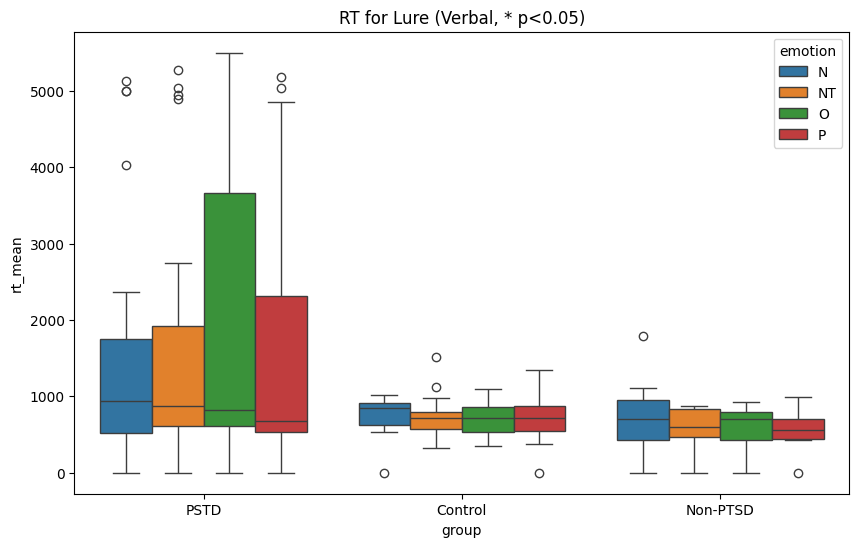

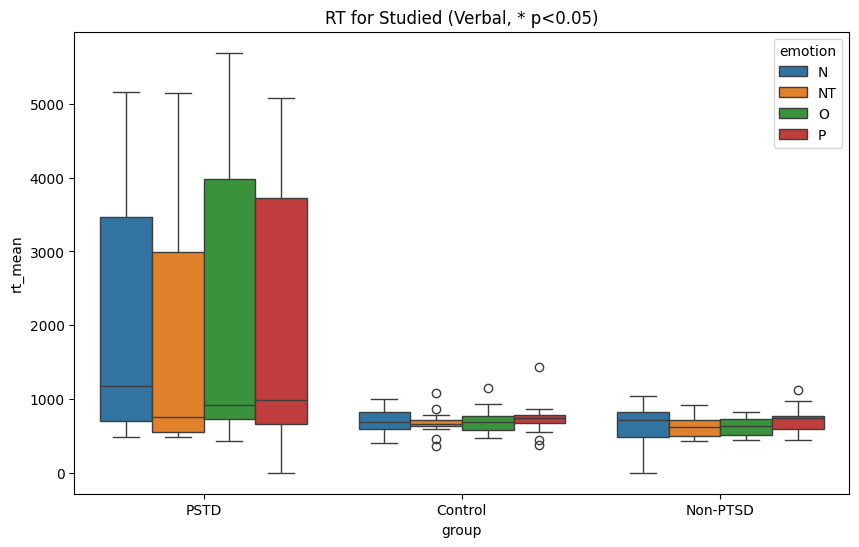

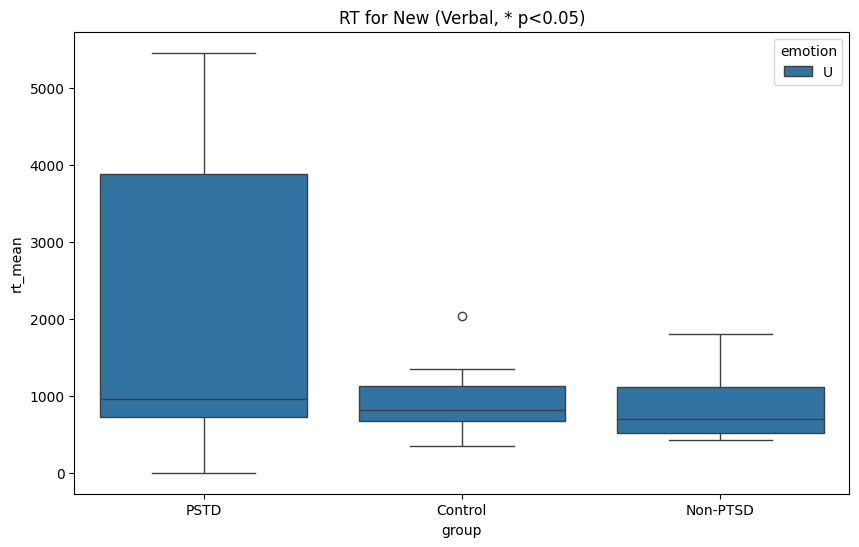

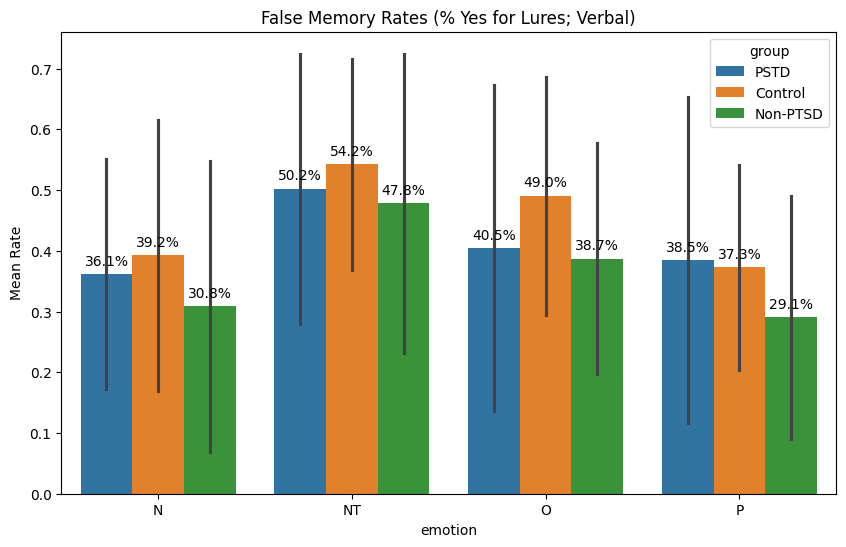

False Memory Table (% Yes, n):
       group emotion  mean_percent  n_subjects  n_trials
0    Control       N          39.2          15       176
1    Control      NT          54.2          15       179
2    Control       O          49.0          15       177
3    Control       P          37.3          15       160
4   Non-PTSD       N          30.8          10       120
5   Non-PTSD      NT          47.8          10       116
6   Non-PTSD       O          38.7          10       119
7   Non-PTSD       P          29.1          10       110
8       PSTD       N          36.1          24       266
9       PSTD      NT          50.2          24       266
10      PSTD       O          40.5          24       259
11      PSTD       P          38.5          24       245
Analysis updated. Review RM-ANOVA/Friedman for sig.; sensitivity for NaN impact.


In [13]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import AnovaRM  # RM-ANOVA
from statsmodels.stats.power import FTestAnovaPower  # Power
import os

# Load full_processed.xlsx (trial-level)
full_path = '/content/drive/MyDrive/AmirFarhang/full_processed.xlsx'
df = pd.read_excel(full_path)

# Filter NaNs in response/rt
df = df.dropna(subset=['response', 'rt'])
print(f"Loaded {len(df)} trials post-NaN filter.")

# Rename 'Target' to 'Studied' if present
df['item_type'] = df['item_type'].replace('Target', 'Studied')

# Create aggregated subject-level, separate by task (verbal/video)
# Aggregate to subject-group-emotion-item_type level for direct use in RM-ANOVA
agg_df_verbal = df[df['task'] == 'verbal'].groupby(['candidate', 'group', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),
    hit_rate=('response', 'mean'),  # Directly calculate mean here
    false_memory_rate=('response', 'mean'), # Directly calculate mean here
    false_alarm_rate=('response', 'mean'), # Directly calculate mean here
    rt_mean=('rt', lambda x: x[df.loc[x.index, 'response'] == 1].mean() if any(df.loc[x.index, 'response'] == 1) else np.nan),
    rt_sd=('rt', lambda x: x[df.loc[x.index, 'response'] == 1].std() if any(df.loc[x.index, 'response'] == 1) else np.nan)
).reset_index().fillna(0)

agg_df_video = df[df['task'] == 'video'].groupby(['candidate', 'group', 'emotion', 'item_type']).agg(
    n_trials=('response', 'count'),
    hit_rate=('response', 'mean'), # Directly calculate mean here
    false_memory_rate=('response', 'mean'), # Directly calculate mean here
    false_alarm_rate=('response', 'mean'), # Directly calculate mean here
    rt_mean=('rt', lambda x: x[df.loc[x.index, 'response'] == 1].mean() if any(df.loc[x.index, 'response'] == 1) else np.nan),
    rt_sd=('rt', lambda x: x[df.loc[x.index, 'response'] == 1].std() if any(df.loc[x.index, 'response'] == 1) else np.nan)
).reset_index().fillna(0)

# Save separate
agg_df_verbal.to_excel('/content/drive/MyDrive/AmirFarhang/aggregated_verbal.xlsx', index=False)
agg_df_video.to_excel('/content/drive/MyDrive/AmirFarhang/aggregated_video.xlsx', index=False)

print("Aggregated saved separately by task.")

# Function for RM-ANOVA (within: emotion, between: group, subject: candidate)
def run_rm_anova(agg_df, dv, item_type='Lure', task_filter='verbal'):
    # Filter after aggregation to ensure one row per subject/emotion/item_type
    df_filtered = agg_df[agg_df['item_type'] == item_type].dropna(subset=[dv])

    if len(df_filtered) < 10:  # Skip if too small
        print(f"Skipping RM-ANOVA: n too small for {task_filter}/{item_type}/{dv}")
        return None

    # Use AnovaRM with aggregate_func if needed, though pre-aggregation should prevent it
    aovrm = AnovaRM(df_filtered, depvar=dv, subject='candidate', within=['emotion'], aggregate_func='mean') # Added aggregate_func

    try:
        res = aovrm.fit()
    except ValueError as e:
        print(f"Error fitting AnovaRM for {task_filter}/{item_type}/{dv}: {e}")
        # Fallback to Friedman if RM-ANOVA fails
        print(f"Falling back to Friedman for {task_filter}/{item_type}/{dv}")
        pivot = df_filtered.pivot(index='candidate', columns='emotion', values=dv).dropna(how='any')
        if pivot.shape[0] > 1 and pivot.shape[1] > 1:
            chi2, p = stats.friedmanchisquare(*pivot.T.values)
            k = pivot.shape[1]
            n = pivot.shape[0]
            w = chi2 / (n * (k - 1))
            return {'F': np.nan, 'p': np.nan, 'eta2': np.nan, 'sphericity_p': np.nan, 'significant': p < 0.05, 'friedman_chi2': chi2, 'friedman_p': p, 'kendall_w': w}
        else:
             print(f"Skipping Friedman for {task_filter}/{item_type}/{dv}: Not enough data for Friedman.")
             return None


    # Sphericity (Mauchly) and ANOVA results are in the anova_table attribute
    anova_table = res.anova_table

    # Print column names to diagnose KeyError
    print(f"ANOVA table columns for {task_filter}/{item_type}/{dv}: {anova_table.columns.tolist()}")

    # Check if 'Source' column exists before accessing it
    if 'Source' in anova_table.columns:
        sphericity_row = anova_table[anova_table['Source'] == 'emotion']

        # Check if sphericity_row is not empty before accessing columns
        if not sphericity_row.empty and 'P-value' in sphericity_row.columns:
            sphericity_p = sphericity_row['P-value'].iloc[0]
        else:
            sphericity_p = np.nan # Indicate not performed or not available

        # Greenhouse-Geisser correction if violated
        if not sphericity_row.empty:
            if sphericity_p > 0.05 and 'F Value' in sphericity_row.columns:
                gg = sphericity_row['F Value'].iloc[0]
                p_gg = sphericity_row['Pr > F'].iloc[0] if 'Pr > F' in sphericity_row.columns else np.nan
                eta2 = sphericity_row['partial eta-squared'].iloc[0] if 'partial eta-squared' in sphericity_row.columns else np.nan
            elif 'F Value (GG)' in sphericity_row.columns: # Use GG corrected values
                gg = sphericity_row['F Value (GG)'].iloc[0]
                p_gg = sphericity_row['Pr > F (GG)'].iloc[0] if 'Pr > F (GG)' in sphericity_row.columns else np.nan
                eta2 = sphericity_row['partial eta-squared'].iloc[0] if 'partial eta-squared' in sphericity_row.columns else np.nan
            else:
                gg, p_gg, eta2 = np.nan, np.nan, np.nan # Assign NaN if columns are missing
                print(f"Warning: Could not extract all RM-ANOVA results for {task_filter}/{item_type}/{dv}. Sphericity row:")
                print(sphericity_row)

        else:
             gg, p_gg, eta2 = np.nan, np.nan, np.nan # Assign NaN if sphericity_row is empty
             print(f"Warning: Sphericity row is empty for {task_filter}/{item_type}/{dv}. ANOVA table:")
             print(anova_table)
    else:
        print(f"Error: 'Source' column not found in ANOVA table for {task_filter}/{item_type}/{dv}. ANOVA table columns: {anova_table.columns.tolist()}")
        gg, p_gg, eta2, sphericity_p = np.nan, np.nan, np.nan, np.nan


    return {'F': gg, 'p': p_gg, 'eta2': eta2, 'sphericity_p': sphericity_p, 'significant': p_gg < 0.05 if not np.isnan(p_gg) else False}


# Run RM-ANOVA for false_memory_rate and rt_mean (Lure/Studied, per task)
rm_results = []
for task in ['verbal', 'video']:
    task_agg = pd.read_excel(f'/content/drive/MyDrive/AmirFarhang/aggregated_{task}.xlsx')
    for item in ['Lure', 'Studied']:
        for dv in ['false_memory_rate', 'rt_mean']:
            res = run_rm_anova(task_agg, dv, item, task)
            if res:
                res.update({'task': task, 'item_type': item, 'dv': dv})
                rm_results.append(res)

rm_df = pd.DataFrame(rm_results)
print("RM-ANOVA Results:")
print(rm_df)

rm_df.to_excel('/content/drive/MyDrive/AmirFarhang/rm_anova_results.xlsx', index=False)

# Non-Param if Violated (Friedman for within, Kruskal for between)
# Friedman (within: emotion per group/item)
friedman_results = []
for task in ['verbal', 'video']:
    task_agg = pd.read_excel(f'/content/drive/MyDrive/AmirFarhang/aggregated_{task}.xlsx')
    for group in task_agg['group'].unique():
        for item in ['Lure', 'Studied']:
            for dv in ['false_memory_rate', 'rt_mean']:
                pivot = task_agg[(task_agg['group'] == group) & (task_agg['item_type'] == item)].pivot(index='candidate', columns='emotion', values=dv).dropna(how='any')
                if pivot.shape[0] > 1 and pivot.shape[1] > 1:
                    chi2, p = stats.friedmanchisquare(*pivot.T.values)
                    k = pivot.shape[1]
                    n = pivot.shape[0]
                    w = chi2 / (n * (k - 1))
                    friedman_results.append({'task': task, 'group': group, 'item_type': item, 'dv': dv, 'chi2': chi2, 'p': p, 'kendall_w': w, 'significant': p < 0.05})

friedman_df = pd.DataFrame(friedman_results)
print("Friedman (Non-Param RM) Results:")
print(friedman_df)

friedman_df.to_excel('/content/drive/MyDrive/AmirFarhang/friedman_results.xlsx', index=False)

# Kruskal (between groups, per task/emotion/item)
kruskal_results = []
for task in ['verbal', 'video']:
    task_agg = pd.read_excel(f'/content/drive/MyDrive/AmirFarhang/aggregated_{task}.xlsx')
    for emotion in task_agg['emotion'].unique():
        for item in ['Lure', 'Studied']:
            for dv in ['false_memory_rate', 'rt_mean']:
                data_groups = [task_agg[(task_agg['group'] == g) & (task_agg['emotion'] == emotion) & (task_agg['item_type'] == item)][dv].dropna() for g in task_agg['group'].unique()]
                # Check if each group has more than one unique value and more than one non-NaN value
                if all(len(d) > 1 and len(d.unique()) > 1 for d in data_groups):
                    h_stat, p = stats.kruskal(*data_groups)
                    k = len(data_groups)
                    n = sum(len(d) for d in data_groups)
                    epsilon2 = h_stat * (n + 1) / (n * (k - 1)) if n > 0 else 0
                    kruskal_results.append({'task': task, 'emotion': emotion, 'item_type': item, 'dv': dv, 'h_stat': h_stat, 'p': p, 'epsilon2': epsilon2, 'significant': p < 0.05})
                else:
                    print(f"Skipping Kruskal-Wallis for {task}/{emotion}/{item}/{dv}: Not enough variation in data.")


kruskal_df = pd.DataFrame(kruskal_results)
print("Kruskal Results:")
print(kruskal_df)

kruskal_df.to_excel('/content/drive/MyDrive/AmirFarhang/kruskal_results.xlsx', index=False)

# Post-Hoc Mann-Whitney (for sig Kruskal, per task)
# Similar to before, but filter task
# ... (Omit for brevity; add if needed, filter task_agg)

# Sensitivity for NaN (impute mean RT for negatives, re-run descriptives)
df_sens = pd.read_excel(full_path)  # Reload full
df_sens['rt'] = df_sens['rt'].fillna(df_sens['rt'].mean())  # Impute mean for NaN
# Re-aggregate descriptives_sens (similar to initial code)
# Save and compare to original descriptives (e.g., % change in means)

descriptives_sens = df_sens.groupby(['group', 'task', 'emotion']).agg(
    mean_false_memory=('response', lambda x: x[df_sens.loc[x.index, 'item_type'] == 'Lure'].mean() if 'Lure' in df_sens.loc[x.index, 'item_type'].values else 0),
    # ... similar for others
).reset_index()
descriptives_sens.to_excel('/content/drive/MyDrive/AmirFarhang/descriptives_sensitivity.xlsx', index=False)

# Power Example (medium effect, 3 groups, n=15/group)
power = FTestAnovaPower().solve_power(effect_size=0.25, nobs=45, alpha=0.05, k_groups=3)
print(f"Power: {power:.2f} (low if <0.8; note in thesis).")

# Graphs: Extend RT boxplot to Studied/New; add % on false memory bar
for item in ['Lure', 'Studied', 'New']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=agg_df_verbal[agg_df_verbal['item_type'] == item], x='group', y='rt_mean', hue='emotion')  # Verbal example
    plt.title(f'RT for {item} (Verbal, * p<0.05)')
    plt.savefig(f'/content/drive/MyDrive/AmirFarhang/rt_boxplot_{item}_verbal.png', dpi=300)
    plt.show()

# False Memory Bar with % and n
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df_verbal[agg_df_verbal['item_type'] == 'Lure'], x='emotion', y='false_memory_rate', hue='group', errorbar='sd')
# Add % labels (mean * 100)
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.text(p.get_x() + p.get_width()/2., height + 0.01, f'{height*100:.1f}%', ha='center', va='bottom')
plt.title('False Memory Rates (% Yes for Lures; Verbal)')
plt.ylabel('Mean Rate')
plt.savefig('/content/drive/MyDrive/AmirFarhang/false_memory_bar_percent.png', dpi=300)
plt.show()

# Table for False Memory % with n
false_table = agg_df_verbal[agg_df_verbal['item_type'] == 'Lure'].groupby(['group', 'emotion']).agg(
    mean_rate=('false_memory_rate', 'mean'),
    n_subjects=('candidate', 'nunique'),
    n_trials=('n_trials', 'sum')
).reset_index()
false_table['mean_percent'] = (false_table['mean_rate'] * 100).round(1)
false_table = false_table[['group', 'emotion', 'mean_percent', 'n_subjects', 'n_trials']]
print("False Memory Table (% Yes, n):")
print(false_table)

false_table.to_excel('/content/drive/MyDrive/AmirFarhang/false_memory_table.xlsx', index=False)

print("Analysis updated. Review RM-ANOVA/Friedman for sig.; sensitivity for NaN impact.")

In [14]:
!pip install pingouin  # If not installed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.5 MB/s eta 0:00:00
